# Marina Lebedina
## ID: 12249127

# HW 1. Futures Spread Dynamics

### Period: December 2, 2017 - August 31, 2019
### 2nd month: number of days to futures expiration is the smalles available value greater than 30 days
### $X = $ CBT_TU_TU $\Rightarrow$ 2-year US T-Notes
### $Y = $ CBT_TY_TY $\Rightarrow$ 10-year US T-Notes

$$ X_t = \text{CBT_TU_TU}_t $$

$$ Y_t = \text{CBT_TY_TY}_t $$

$$ S_t = Y_t - X_t $$

$$ d_t^{(N)} = S_t - MA_{S_t}^{(N)}, N=[10,20,30,40] $$

# 1. Data Processing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
from scipy.stats import kurtosis, kurtosistest, skew, skewtest, norm, jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from calendar import monthrange
from tqdm import tnrange
import warnings
warnings.filterwarnings('ignore')

@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key="bWbMQmPczynWg63DzkA9")
    return qdata

def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [2]:
# contract1 = 'CBT_FV_FV'
# contract2 = 'CBT_US_US'

contract1 = 'CBT_TU_TU'
contract2 = 'CBT_TY_TY'

start = '2017-12-02'
end = '2019-08-31'

dates = pd.bdate_range(start=start, end=end)
df = pd.DataFrame(index=dates, columns=['Future_TU', 'DtT_TU', 'Future_TY', 'DtT_TY', 'Spread'])

months = ['H', 'M', 'U','Z'] # March, June, September, December
# months = ['F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X', 'Z']
years = ['2018', '2019']
    
for yy in tnrange(len(years), desc='Iterating through years'):
    y = years[yy]
    for mm in tnrange(len(months), desc='Iterating through months'):
        m = months[mm]
        
        # Download from Quandl
        cbt_tu_tu = 'OWF/{}IVM'.format(contract1 + '_' + m + y + '_')
        cbt_ty_ty = 'OWF/{}IVM'.format(contract2 + '_' + m + y + '_')
        
        df_tu = clean_quandl_columns(fetch_quandl((cbt_tu_tu,), trim_start=start, trim_end=end))
        df_ty = clean_quandl_columns(fetch_quandl((cbt_ty_ty,), trim_start=start, trim_end=end))
        data = df_tu[['Future', 'DtT']]
        data = data.rename(columns={"Future": "Future_TU", "DtT": "DtT_TU"})
        data['Future_TY'] = df_ty['Future']
        data['DtT_TY'] = df_ty['DtT']
        data['Spread'] = (data['Future_TY'] - data['Future_TU']).round(6)

        for i,j in data.iterrows():
#             print(str(i.date()), cbt_tu_tu)
            if j['DtT_TU'] <= 30 or j['DtT_TY'] <= 30:
                start = i
                break
            else:
                future_tu = j['Future_TU']
                future_ty = j['Future_TY']
                dt_tu = j['DtT_TU']
                dt_ty = j['DtT_TY']
                spread = j['Spread']
                df.loc[i] = [future_tu, dt_tu, future_ty, dt_ty, spread]     

In [3]:
df[pd.isnull(df).any(axis=1)].index

DatetimeIndex(['2017-12-25', '2018-01-01', '2018-05-15', '2018-05-16',
               '2018-05-17', '2018-05-21', '2019-01-01', '2019-02-15',
               '2019-02-18'],
              dtype='datetime64[ns]', freq=None)

In [4]:
if contract1 == 'CBT_TU_TU' and contract2 == 'CBT_TY_TY':
    # Fill out missing values for May 2018
    missing_date1 = '2018-05-15'
    missing_date2 = '2018-05-21'

    contract1 = 'OWF/CBT_TU_TU_U2018_IVM'
    contract2 = 'OWF/CBT_TY_TY_U2018_IVM'

    df_m_tu = clean_quandl_columns(fetch_quandl((contract1,), trim_start=missing_date1, trim_end=missing_date2))
    df_m_ty = clean_quandl_columns(fetch_quandl((contract2,), trim_start=missing_date1, trim_end=missing_date2))

    data_m = df_m_tu[['Future', 'DtT']]
    data_m = data_m.rename(columns={"Future": "Future_TU", "DtT": "DtT_TU"})
    data_m['Future_TY'] = df_m_ty['Future']
    data_m['DtT_TY'] = df_m_ty['DtT']
    data_m['Spread'] = (data_m['Future_TY'] - data_m['Future_TU']).round(6)

    for i,j in data_m.iterrows():
        if j['DtT_TU'] <= 30 or j['DtT_TY'] <= 30:
            print('less than 30')
        else:
            future_tu = j['Future_TU']
            future_ty = j['Future_TY']
            dt_tu = j['DtT_TU']
            dt_ty = j['DtT_TY']
            spread = j['Spread']
            if (str(df.loc[i]['Future_TU']) == "nan"):
                df.loc[i] = [future_tu, dt_tu, future_ty, dt_ty, spread] 

    # Fill out missing values for Febr 2019
    missing_date1 = '2019-02-15'
    missing_date2 = '2019-02-18'

    contract1 = 'OWF/CBT_TU_TU_M2019_IVM'
    contract2 = 'OWF/CBT_TY_TY_M2019_IVM'

    df_m_tu = clean_quandl_columns(fetch_quandl((contract1,), trim_start=missing_date1, trim_end=missing_date2))
    df_m_ty = clean_quandl_columns(fetch_quandl((contract2,), trim_start=missing_date1, trim_end=missing_date2))

    data_m = df_m_tu[['Future', 'DtT']]
    data_m = data_m.rename(columns={"Future": "Future_TU", "DtT": "DtT_TU"})
    data_m['Future_TY'] = df_m_ty['Future']
    data_m['DtT_TY'] = df_m_ty['DtT']
    data_m['Spread'] = (data_m['Future_TY'] - data_m['Future_TU']).round(6)

    for i,j in data_m.iterrows():
        if j['DtT_TU'] <= 30 or j['DtT_TY'] <= 30:
            print('less than 30')
        else:
            future_tu = j['Future_TU']
            future_ty = j['Future_TY']
            dt_tu = j['DtT_TU']
            dt_ty = j['DtT_TY']
            spread = j['Spread']
            if (str(df.loc[i]['Future_TU']) == "nan"):
                df.loc[i] = [future_tu, dt_tu, future_ty, dt_ty, spread]   
    
    print(df[pd.isnull(df).any(axis=1)].index)
    
print()
df.dropna(inplace=True)
print(df[pd.isnull(df).any(axis=1)].index)

DatetimeIndex(['2017-12-25', '2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [18]:
data = df.copy()

# N-day rolling average of spread, N=10, 20, 30, 40 days
data['MA_10'] = data['Spread'].rolling(10).mean()
data['MA_20'] = data['Spread'].rolling(20).mean()
data['MA_30'] = data['Spread'].rolling(30).mean()
data['MA_40'] = data['Spread'].rolling(40).mean()

# Difference b/t spread and its N-day rolling average
data['Diff_10'] = data['Spread'] - data['MA_10']
data['Diff_20'] = data['Spread'] - data['MA_20']
data['Diff_30'] = data['Spread'] - data['MA_30']
data['Diff_40'] = data['Spread'] - data['MA_40']

data.head(3)

,Future_TU,DtT_TU,Future_TY,DtT_TY,Spread,MA_10,MA_20,MA_30,MA_40,Diff_10,Diff_20,Diff_30,Diff_40
2017-12-04,107.156,115,124.25,106,17.0938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05,107.117,114,124.344,105,17.2266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-06,107.164,113,124.594,104,17.4297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Analysis of $d_t^{(N)}, N=[10,20,30,40]$

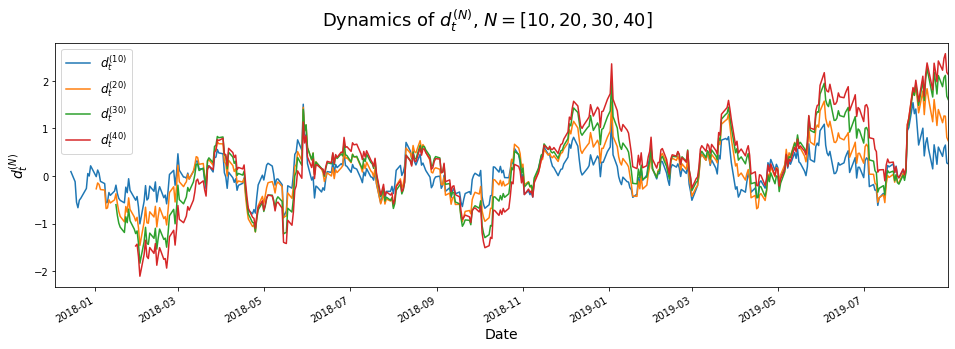

In [19]:
plt.figure(figsize=(16,5))
plt.xlabel('Date', fontsize=14)
plt.ylabel('$d_t^{(N)}$', fontsize=14)
plt.suptitle('Dynamics of $d_t^{(N)}$, $N=[10,20,30,40]$', fontsize=18)
data['Diff_10'].plot(label='$d_t^{(10)}$')
data['Diff_20'].plot(label='$d_t^{(20)}$')
data['Diff_30'].plot(label='$d_t^{(30)}$')
data['Diff_40'].plot(label='$d_t^{(40)}$')
plt.legend(fontsize=12)
None

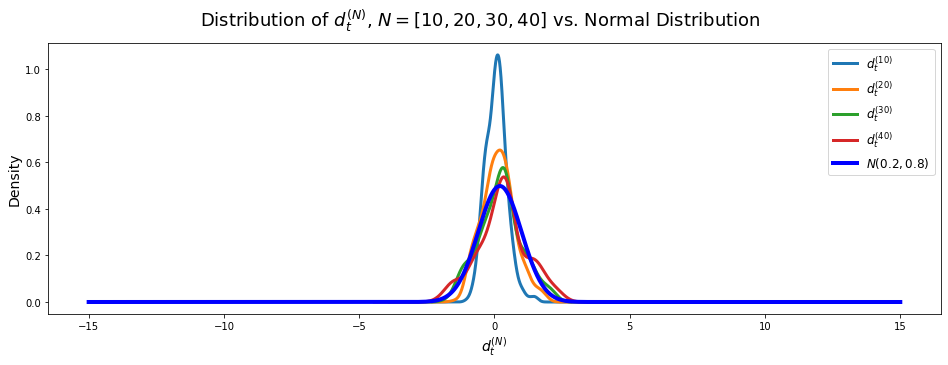

In [20]:
plt.figure(figsize=(16,5))
plt.xlabel('$d_t^{(N)}$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.suptitle('Distribution of $d_t^{(N)}$, $N=[10,20,30,40]$ vs. Normal Distribution', fontsize=18)

data['Diff_10'].plot.kde(label='$d_t^{(10)}$', linewidth=3)
data['Diff_20'].plot.kde(label='$d_t^{(20)}$', linewidth=3)
data['Diff_30'].plot.kde(label='$d_t^{(30)}$', linewidth=3)
data['Diff_40'].plot.kde(label='$d_t^{(40)}$', linewidth=3)

n = 15
plt.plot(np.linspace(-n, n, 1000), norm.pdf(np.linspace(-n, n, 1000), 0.2, 0.8), 
         label='$N(0.2, 0.8)$', linewidth=4, color='blue')

plt.legend(fontsize=12)
None

### Jarque-Bera test

$$H_0: d_t^{(N)} \sim(\mu, \sigma^2) $$

$$H_a: d_t^{(N)} \not\sim(\mu, \sigma^2) $$

In [21]:
print(jarque_bera(data['Diff_10'].dropna()))
print(jarque_bera(data['Diff_20'].dropna()))
print(jarque_bera(data['Diff_30'].dropna()))
print(jarque_bera(data['Diff_40'].dropna()))

(21.323652675935374, 2.342219834716719e-05)
(4.4586335984255285, 0.10760191874479319)
(1.1876329786257238, 0.5522157324977625)
(0.10658544135312183, 0.9481024426706011)


$$ d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \sim \mathcal{N}(\mu, \sigma^2) $$

$$ d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.11 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(20)} \not\sim \mathcal{N}(\mu, \sigma^2) $$

$$ d_t^{(30)} \text{:} \qquad \text{p-value} \approx 0.55 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(30)} \not\sim \mathcal{N}(\mu, \sigma^2) $$

$$ d_t^{(40)} \text{:} \qquad \text{p-value} \approx 0.95 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(40)} \not\sim \mathcal{N}(\mu, \sigma^2) $$

From the plot with distributions above and from the results of Jarque-Bera test we can say that in general differences between spread of futures on 10-y and 2-y US T-Notes and its Moving Averages, i.e. $d_t^{(N)}$ are **Normally Distributed**. $d_t^{(N)}$ approaches Normal Distribution as the size of the "window" used in calculation of Moving Average increases (in reasonable manner): $d_t^{(N)} \rightarrow \mathcal{N}(\mu, \sigma^2) \text{ as } N \uparrow $.

### Zero Excess Kurtosis Hypothesis test

$$H_0: d_t^{(N)} \text{ has Excess Kurtosis equal to ZERO} $$

$$H_a: d_t^{(N)} \text{ has Excess Kurtosis NOT equal to ZERO} $$

In [22]:
print(kurtosistest(data['Diff_10'].dropna()))
print(kurtosistest(data['Diff_20'].dropna()))
print(kurtosistest(data['Diff_30'].dropna()))
print(kurtosistest(data['Diff_40'].dropna()))

KurtosistestResult(statistic=2.536751139675497, pvalue=0.01118864588907413)
KurtosistestResult(statistic=0.015764325530070344, pvalue=0.9874224090014005)
KurtosistestResult(statistic=-0.5214474546332516, pvalue=0.6020551008166615)
KurtosistestResult(statistic=-0.07096124221302653, pvalue=0.9434286019281269)


$$ d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.011 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has Excess Kurtosis equal to zero} $$

$$ d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.99 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(20)} \text{ has Excess Kurtosis not equal to zero} $$

$$ d_t^{(30)} \text{:} \qquad \text{p-value} \approx 0.60 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(30)} \text{ has Excess Kurtosis not equal to zero} $$

$$ d_t^{(40)} \text{:} \qquad \text{p-value} \approx 0.94 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(40)} \text{ has Excess Kurtosis not equal to zero} $$

From the plot of distributions above as well as from Excess Kurtosis Hypothesis test we can conclude that $d_t^{(N)}$ **DO NOT have FAT TAILS**, i.e. $d_t^{(N)}$ do not have many outliers.

### Zero Skewness Hypothesis test

$$H_0: d_t^{(N)} \text{ has Skewness equal to ZERO} $$

$$H_a: d_t^{(N)} \text{ has Skewness NOT equal to ZERO} $$

In [35]:
print(skewtest(data['Diff_10'].dropna()))
print(skewtest(data['Diff_20'].dropna()))
print(skewtest(data['Diff_30'].dropna()))
print(skewtest(data['Diff_40'].dropna()))

SkewtestResult(statistic=3.385626253269689, pvalue=0.000710160332277114)
SkewtestResult(statistic=2.111305297472134, pvalue=0.034746079010005045)
SkewtestResult(statistic=0.9028158694866149, pvalue=0.3666236272348983)
SkewtestResult(statistic=-0.2332119113296768, pvalue=0.815596856935271)


$$ d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has Skewness equal to zero} $$

$$ d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.035 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has Skewness equal to zero} $$

$$ d_t^{(30)} \text{:} \qquad \text{p-value} \approx 0.37 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(30)} \text{ has Skewness not equal to zero} $$

$$ d_t^{(40)} \text{:} \qquad \text{p-value} \approx 0.82 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(40)} \text{ has Skewness not equal to zero} $$


From the plot of distributions above as well as from Skewness Hypothesis test we can conclude that skewness of $d_t^{(N)}$ depends on the size of the "window" used in calculation of Moving Average and tends toward "right". Skewness decreases as "window" size increases: $\text{Skewness} \downarrow \text{ as } N \uparrow $.

### Statistics

In [24]:
statistics = pd.DataFrame(columns=['Mean', 'Std.dev', '25th Q', '50th Q', '75th Q', 
                                   'Min', 'Max', 'Skewness', 'Excess Kurtosis'])

def table_row(name):
    df = data.copy()
    df.dropna(inplace=True)
    stats = pd.to_numeric(df[name]).describe()
    return [stats[1], stats[2], stats[4], stats[5], stats[6], stats[3], stats[7],
            df[name].skew(), df[name].kurtosis()]
    
statistics.loc['$d_t^{(10)}$'] = table_row('Diff_10')
statistics.loc['$d_t^{(20)}$'] = table_row('Diff_20')
statistics.loc['$d_t^{(30)}$'] = table_row('Diff_30')
statistics.loc['$d_t^{(40)}$'] = table_row('Diff_40')

statistics

,Mean,Std.dev,25th Q,50th Q,75th Q,Min,Max,Skewness,Excess Kurtosis
$d_t^{(10)}$,0.088646,0.391403,-0.192188,0.083594,0.304844,-1.004688,1.543282,0.363336,0.816883
$d_t^{(20)}$,0.173649,0.603054,-0.190547,0.174219,0.535547,-1.457031,1.901250,0.200408,0.073584
$d_t^{(30)}$,0.241115,0.778943,-0.254167,0.260156,0.638803,-1.831510,2.266302,0.088644,-0.038729
$d_t^{(40)}$,0.293358,0.913334,-0.221680,0.305469,0.732187,-2.104492,2.571992,-0.027734,-0.042045


### Stationarity check for $d_t^{(N)}, N=[10,20,30,40]$

$$ H_0: d_t^{(N)} \text{is a unit root process} $$

$$ H_a: d_t^{(N)} \text{is NOT a unit root process} $$

In [25]:
diff10 = pd.to_numeric(data['Diff_10']).dropna()
diff20 = pd.to_numeric(data['Diff_20']).dropna()
diff30 = pd.to_numeric(data['Diff_30']).dropna()
diff40 = pd.to_numeric(data['Diff_40']).dropna()

print(adfuller(diff10)[1])
print(adfuller(diff20)[1])
print(adfuller(diff30)[1])
print(adfuller(diff40)[1])

7.260816708555985e-09
0.008616974148851358
0.0502180406957995
0.10208614641868091


$$ d_t^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(10)} \text{ has a unit root} \Rightarrow d_t^{(10)} \text{ is NOT STATIONARY} $$

$$ d_t^{(20)} \text{:} \qquad \text{p-value} \approx 0.0086 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } d_t^{(20)} \text{ has a unit root} \Rightarrow d_t^{(20)} \text{ is NOT STATIONARY} $$

$$ d_t^{(30)} \text{:} \qquad \text{p-value} \approx 0.0502 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(30)} \text{ doesn't have a unit root} \Rightarrow d_t^{(30)} \text{ is STATIONARY} $$

$$ d_t^{(40)} \text{:} \qquad \text{p-value} \approx 0.10 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } d_t^{(40)} \text{ doesnt' have a unit root} \Rightarrow d_t^{(40)} \text{ is STATIONARY} $$

### Regimes switching

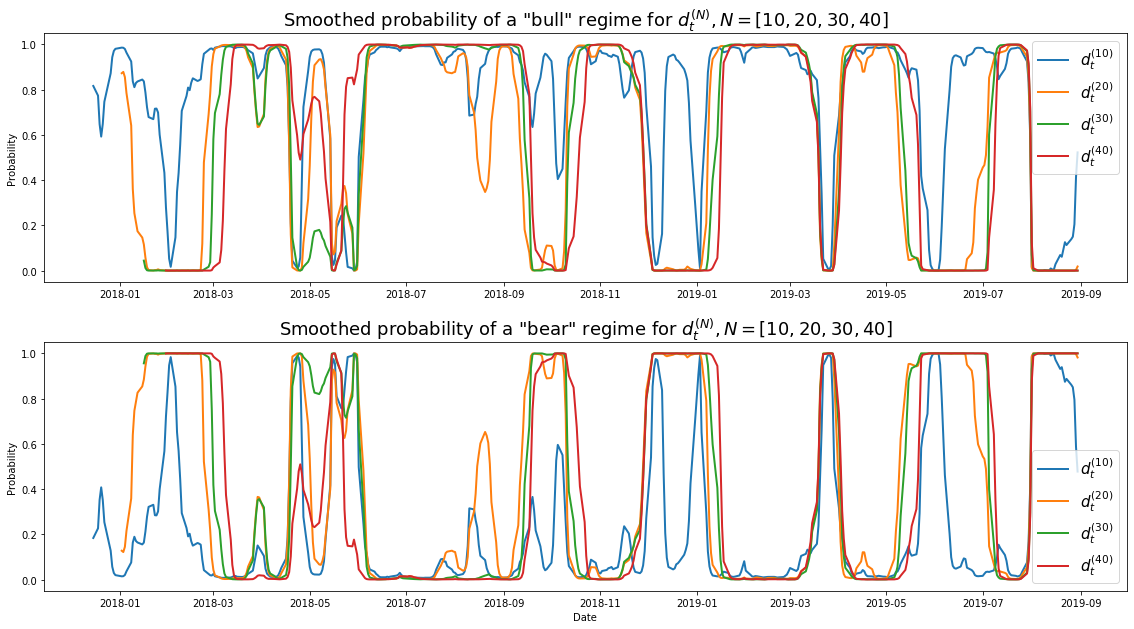

In [26]:
mr10 = sm.tsa.MarkovRegression(diff10, k_regimes=2, trend='nc', switching_variance=True).fit()
mr20 = sm.tsa.MarkovRegression(diff20, k_regimes=2, trend='nc', switching_variance=True).fit()
mr30 = sm.tsa.MarkovRegression(diff30, k_regimes=2, trend='nc', switching_variance=True).fit()
mr40 = sm.tsa.MarkovRegression(diff40, k_regimes=2, trend='nc', switching_variance=True).fit()

fig, axes = plt.subplots(2, figsize=(16,9))
plt.rcParams.update({'font.size': 15})
ax = axes[0]
ax.plot(mr10.smoothed_marginal_probabilities[0], label='$d_t^{(10)}$', linewidth=2)
ax.plot(mr20.smoothed_marginal_probabilities[0], label='$d_t^{(20)}$', linewidth=2)
ax.plot(mr30.smoothed_marginal_probabilities[0], label='$d_t^{(30)}$', linewidth=2)
ax.plot(mr40.smoothed_marginal_probabilities[0], label='$d_t^{(40)}$', linewidth=2)
ax.set(title='Smoothed probability of a "bull" regime for $d_t^{(N)}, N=[10,20,30,40]$')
ax.set_ylabel('Probability')
ax.legend()

ax = axes[1]
ax.plot(mr10.smoothed_marginal_probabilities[1], label='$d_t^{(10)}$', linewidth=2)
ax.plot(mr20.smoothed_marginal_probabilities[1], label='$d_t^{(20)}$', linewidth=2)
ax.plot(mr30.smoothed_marginal_probabilities[1], label='$d_t^{(30)}$', linewidth=2)
ax.plot(mr40.smoothed_marginal_probabilities[1], label='$d_t^{(40)}$', linewidth=2)
ax.set(title='Smoothed probability of a "bear" regime for $d_t^{(N)}, N=[10,20,30,40]$')
ax.set_xlabel('Date')
ax.set_ylabel('Probability')
ax.legend()

fig.tight_layout()

### Expected duration of "bull" and "bear" regimes for $d_t^{(N)}, N=[10,20,30,30]$

In [27]:
states = pd.DataFrame(index=['$d_t^{(10)}$', '$d_t^{(20)}$', '$d_t^{(30)}$', '$d_t^{(40)}$'], 
                      columns=['Bull regime', 'Bear regime'])
states.loc['$d_t^{(10)}$'] = [round(mr10.expected_durations[0],2), round(mr10.expected_durations[1],2)]
states.loc['$d_t^{(20)}$'] = [round(mr20.expected_durations[0],2), round(mr20.expected_durations[1],2)]
states.loc['$d_t^{(30)}$'] = [round(mr30.expected_durations[0],2), round(mr30.expected_durations[1],2)]
states.loc['$d_t^{(40)}$'] = [round(mr40.expected_durations[0],2), round(mr40.expected_durations[1],2)]
states

,Bull regime,Bear regime
$d_t^{(10)}$,24.64,7.37
$d_t^{(20)}$,23.85,18.3
$d_t^{(30)}$,30.17,27.52
$d_t^{(40)}$,33.96,26.81


### Seasonality decomposition of $d_t^{(20)}$

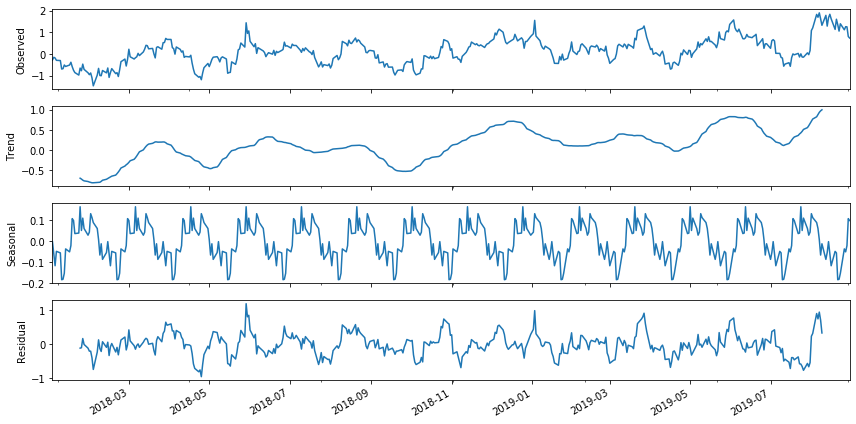

In [28]:
decomp20 = sm.tsa.seasonal_decompose(diff20, model='additive', freq=30)

plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
decomp20.plot()
None

From the plot of $d_t^{(N)}$ dynamics as well as from Stationarity Hypothesis test and "Regimes switching" and "Seasonality decomposition" above we can conclude that stationarity of $d_t^{(N)}$ depends on the size of the "window" used in calculation of Moving Average. $d_t^{(N)}$ with higher $N$ are stationary, which means that statistical properties of $d_t^{(N)}$ do not change over time. While $d_t^{(N)}$ with small $N$ are non-stationary and seem to have a more evident **upward trend** over a long-term horizon. We can also see that $d_t^{(N)}$ has an evident "seasonality" component and the average number of days before "up/down regime switching" is **30 days**. 

# 3. Analysis of $S_t$ and $MA_{S_t}^{(N)}, N=[10,20,30,40]$

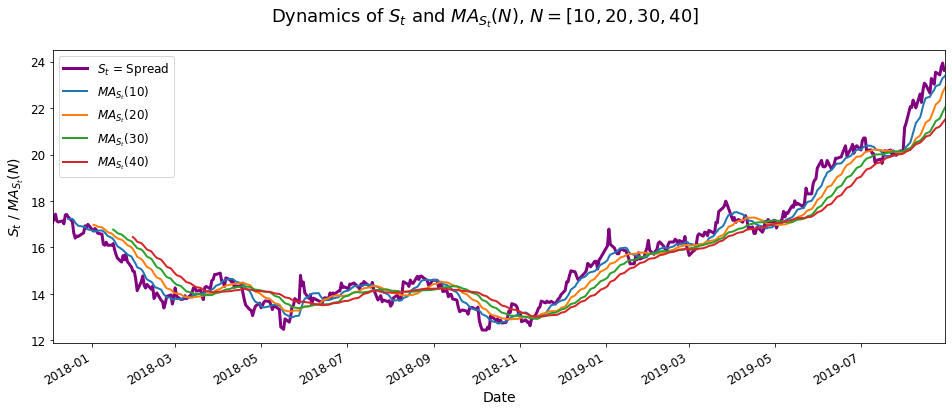

In [29]:
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=14)
plt.ylabel('$S_t$ / $MA_{S_t}(N)$', fontsize=14)
plt.suptitle('Dynamics of $S_t$ and $MA_{S_t}(N)$, $N=[10,20,30,40]$', fontsize=18)
data['Spread'].plot(fontsize=12, label='$S_t$ = Spread', linewidth=3, color='purple')
data['MA_10'].plot(label='$MA_{S_t}(10)$', linewidth=2)
data['MA_20'].plot(label='$MA_{S_t}(20)$', linewidth=2)
data['MA_30'].plot(label='$MA_{S_t}(30)$', linewidth=2)
data['MA_40'].plot(label='$MA_{S_t}(40)$', linewidth=2)
plt.legend(fontsize=12)
None

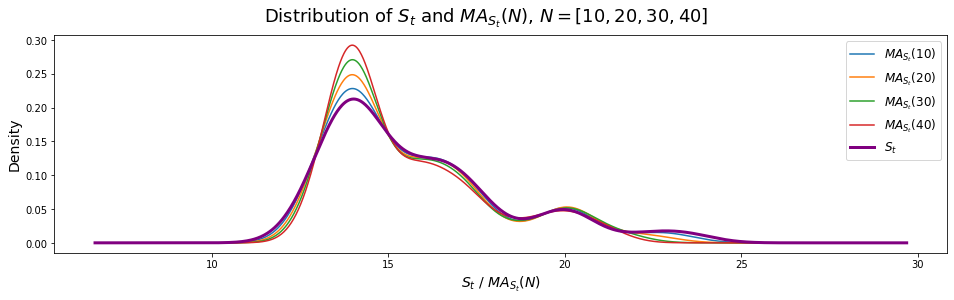

In [30]:
plt.figure(figsize=(16,4))
plt.xlabel('$S_t$ / $MA_{S_t}(N)$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.suptitle('Distribution of $S_t$ and $MA_{S_t}(N)$, $N=[10,20,30,40]$', fontsize=18)

data['MA_10'].plot.kde(label='$MA_{S_t}(10)$')
data['MA_20'].plot.kde(label='$MA_{S_t}(20)$')
data['MA_30'].plot.kde(label='$MA_{S_t}(30)$')
data['MA_40'].plot.kde(label='$MA_{S_t}(40)$')
data['Spread'].plot.kde(label='$S_t$', linewidth=3, color='purple')

plt.legend(fontsize=12)
None

### Jarque-Bera test

$$H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \sim N(\mu, \sigma^2) $$

$$H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \not\sim N(\mu, \sigma^2) $$

In [31]:
print(jarque_bera(data['Spread'].dropna()))
print(jarque_bera(data['MA_10'].dropna()))
print(jarque_bera(data['MA_20'].dropna()))
print(jarque_bera(data['MA_30'].dropna()))
print(jarque_bera(data['MA_40'].dropna()))

(108.87239795716852, 0.0)
(100.16238746335024, 0.0)
(88.7694881757379, 0.0)
(83.78406202401888, 0.0)
(87.1603758507754, 0.0)


$$ S_t \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } S_t \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(10)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(20)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(30)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(30)} \sim N(\mu, \sigma^2) $$

$$ MA_{S_t}^{(40)} \text{:} \qquad \text{p-value} = 0.00 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(40)} \sim N(\mu, \sigma^2) $$

From the plot with distributions above and from the results of Jarque-Bera test we can say that in spread of futures on 10-y and 2-y US T-Notes and its Moving Averages, i.e. $S_t$ and $MA_{S_t}^{(N)}$ are **NOT Normally Distributed**.

### Zero Excess Kurtosis Hypothesis test

$$H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Excess Kurtosis equal to ZERO} $$

$$H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Excess Kurtosis NOT equal to ZERO} $$

In [32]:
print(kurtosistest(data['Spread'].dropna()))
print(kurtosistest(data['MA_10'].dropna()))
print(kurtosistest(data['MA_20'].dropna()))
print(kurtosistest(data['MA_30'].dropna()))
print(kurtosistest(data['MA_40'].dropna()))

KurtosistestResult(statistic=2.558632315184742, pvalue=0.010508482130675323)
KurtosistestResult(statistic=2.184720414685481, pvalue=0.028909352417558896)
KurtosistestResult(statistic=1.5353783810152692, pvalue=0.12469091096638096)
KurtosistestResult(statistic=1.0512681073611467, pvalue=0.2931354704223267)
KurtosistestResult(statistic=1.1734852352300398, pvalue=0.24060127434703227)


$$ S_t \text{:} \qquad \text{p-value} \approx 0.011 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } S_t \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.028 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(10)} \text{ has Excess Kurtosis equal to zero} $$

$$ MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.12 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(20)} \text{ has Excess Kurtosis not equal to zero} $$

$$ MA_{S_t}^{(30)} \text{:} \qquad \text{p-value} \approx 0.29 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(30)} \text{ has Excess Kurtosis not equal to zero} $$

$$ MA_{S_t}^{(40)} \text{:} \qquad \text{p-value} \approx 0.24 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } MA_{S_t}^{(40)} \text{ has Excess Kurtosis not equal to zero} $$

From the plot of distributions above as well as from Excess Kurtosis Hypothesis test we can conclude that distribution of spread $S_t$ itself has many outliers. When using Moving Average with high enough "window" size outliers seem to be smoothed and we can say that distribution of Moving Average of $S_t$ with high enough "window" size does not have fat tails.

### Zero Skewness Hypothesis test

$$H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Skewness equal to ZERO} $$

$$H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{ has Skewness NOT equal to ZERO} $$

In [33]:
print(skewtest(data['Spread'].dropna()))
print(skewtest(data['MA_10'].dropna()))
print(skewtest(data['MA_20'].dropna()))
print(skewtest(data['MA_30'].dropna()))
print(skewtest(data['MA_40'].dropna()))

SkewtestResult(statistic=8.274930372491484, pvalue=1.2853070437520228e-16)
SkewtestResult(statistic=8.09239024177574, pvalue=5.850511396692791e-16)
SkewtestResult(statistic=7.8268707665599555, pvalue=5.0016275016315e-15)
SkewtestResult(statistic=7.690751747476504, pvalue=1.462730089514193e-14)
SkewtestResult(statistic=7.77347904735441, pvalue=7.635928972888086e-15)


$$ S_t \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } S_t \text{ has Skewness equal to zero} $$

$$ MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(10)} \text{ has Skewness equal to zero} $$

$$ MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(20)} \text{ has Skewness equal to zero} $$

$$ MA_{S_t}^{(30)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(30)} \text{ has Skewness equal to zero} $$

$$ MA_{S_t}^{(40)} \text{:} \qquad \text{p-value} \approx 0.00 < 0.05 \Rightarrow \text{ reject } H_0 \text{ that } MA_{S_t}^{(40)} \text{ has Skewness equal to zero} $$

From the plot of distributions above as well as from Skewness Hypothesis test it is obvious that **skewness** of $S_t$ as well as of $MA_{S_t}^{(N)}$ is **positive**.

### Statistics

In [34]:
statistics = pd.DataFrame(columns=['Mean', 'Std.dev', '25th Q', '50th Q', '75th Q', 
                                   'Min', 'Max', 'Skewness', 'Excess Kurtosis'])

def table_row(name):
    df = data.copy()
    df.dropna(inplace=True)
    stats = pd.to_numeric(df[name]).describe()
    return [stats[1], stats[2], stats[4], stats[5], stats[6], stats[3], stats[7],
            df[name].skew(), df[name].kurtosis()]
    
statistics.loc['$S_t$'] = table_row('Spread')
statistics.loc['$MA_{S_t}^{(10)}$'] = table_row('MA_10')
statistics.loc['$MA_{S_t}^{(20)}$'] = table_row('MA_20')
statistics.loc['$MA_{S_t}^{(30)}$'] = table_row('MA_30')
statistics.loc['$MA_{S_t}^{(40)}$'] = table_row('MA_40')

statistics

,Mean,Std.dev,25th Q,50th Q,75th Q,Min,Max,Skewness,Excess Kurtosis
$S_t$,15.769775,2.689171,13.789062,14.609375,17.078125,12.437500,23.937500,1.184482,0.596720
$MA_{S_t}^{(10)}$,15.681130,2.542297,13.837500,14.580469,16.986094,12.720313,23.405938,1.173299,0.527368
$MA_{S_t}^{(20)}$,15.596126,2.388911,13.918359,14.448047,16.992187,12.901563,22.918672,1.137691,0.364833
$MA_{S_t}^{(30)}$,15.528660,2.257679,13.989583,14.325781,16.855469,12.925260,22.054219,1.112434,0.242623
$MA_{S_t}^{(40)}$,15.476417,2.152340,14.002734,14.287305,16.694609,13.022070,21.525625,1.121561,0.282353


### Stationarity check for $S_t$ and $MA_{S_t}^{(N)}, N=[10,20,30,40]$

$$ H_0: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{is a unit root process} $$

$$ H_a: S_t \text{ or } \text{MA}_{S_t}^{(N)} \text{is NOT a unit root process} $$

In [22]:
spread = pd.to_numeric(data['Spread']).dropna()
ma10 = pd.to_numeric(data['MA_10']).dropna()
ma20 = pd.to_numeric(data['MA_20']).dropna()
ma30 = pd.to_numeric(data['MA_30']).dropna()
ma40 = pd.to_numeric(data['MA_40']).dropna()

print(adfuller(spread)[1])
print(adfuller(ma10)[1])
print(adfuller(ma20)[1])
print(adfuller(ma30)[1])
print(adfuller(ma40)[1])

0.9981015385282687
0.9947672145091315
0.9781522701856294
0.9984971787093383
0.9981701699572214


$$ S_t \text{:} \qquad \text{p-value} \approx 1.0 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

$$ MA_{S_t}^{(10)} \text{:} \qquad \text{p-value} \approx 1.0 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

$$ MA_{S_t}^{(20)} \text{:} \qquad \text{p-value} \approx 1.0 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

$$ MA_{S_t}^{(30)} \text{:} \qquad \text{p-value} \approx 1.0 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

$$ MA_{S_t}^{(40)} \text{:} \qquad \text{p-value} \approx 1.0 > 0.05 \Rightarrow \text{ reject } H_a \text{ that } S_t \text{ doesn't have a unit root} \Rightarrow S_t \text{ is STATIONARY} $$

### Regimes switching

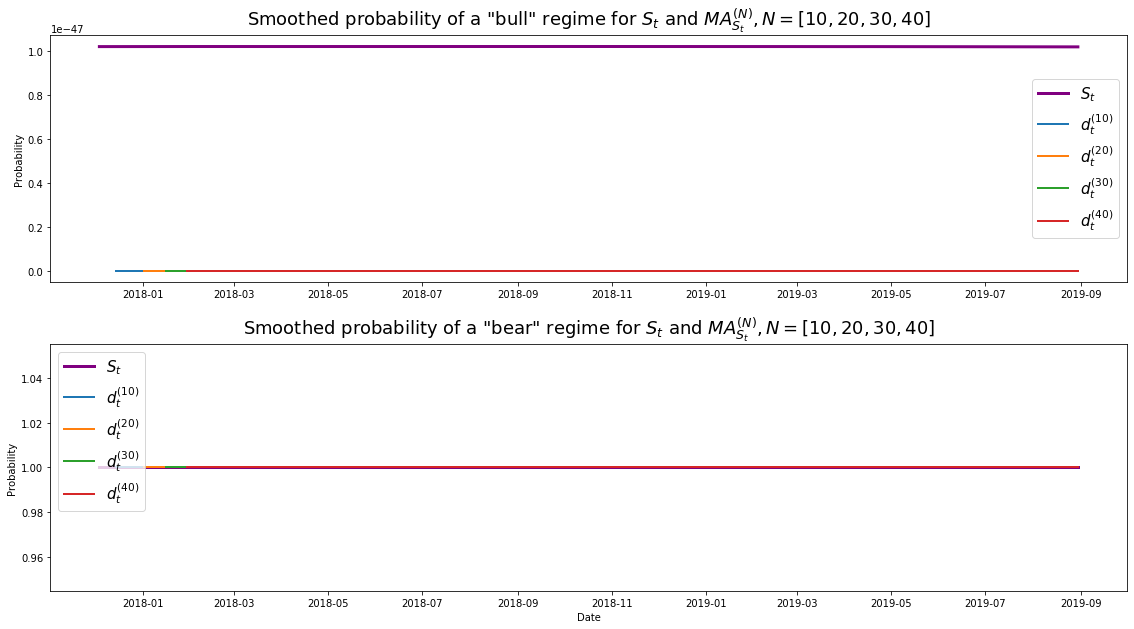

In [23]:
mr = sm.tsa.MarkovRegression(spread, k_regimes=2, trend='nc', switching_variance=True).fit()
mr10 = sm.tsa.MarkovRegression(ma10, k_regimes=2, trend='nc', switching_variance=True).fit()
mr20 = sm.tsa.MarkovRegression(ma20, k_regimes=2, trend='nc', switching_variance=True).fit()
mr30 = sm.tsa.MarkovRegression(ma30, k_regimes=2, trend='nc', switching_variance=True).fit()
mr40 = sm.tsa.MarkovRegression(ma40, k_regimes=2, trend='nc', switching_variance=True).fit()

fig, axes = plt.subplots(2, figsize=(16,9))
plt.rcParams.update({'font.size': 15})
ax = axes[0]
ax.plot(mr.smoothed_marginal_probabilities[0], label='$S_t$', linewidth=3, color='purple')
ax.plot(mr10.smoothed_marginal_probabilities[0], label='$d_t^{(10)}$', linewidth=2)
ax.plot(mr20.smoothed_marginal_probabilities[0], label='$d_t^{(20)}$', linewidth=2)
ax.plot(mr30.smoothed_marginal_probabilities[0], label='$d_t^{(30)}$', linewidth=2)
ax.plot(mr40.smoothed_marginal_probabilities[0], label='$d_t^{(40)}$', linewidth=2)
ax.set(title='Smoothed probability of a "bull" regime for $S_t$ and $MA_{S_t}^{(N)}, N=[10,20,30,40]$')
ax.set_ylabel('Probability')
ax.legend()

ax = axes[1]
ax.plot(mr.smoothed_marginal_probabilities[1], label='$S_t$', linewidth=3, color='purple')
ax.plot(mr10.smoothed_marginal_probabilities[1], label='$d_t^{(10)}$', linewidth=2)
ax.plot(mr20.smoothed_marginal_probabilities[1], label='$d_t^{(20)}$', linewidth=2)
ax.plot(mr30.smoothed_marginal_probabilities[1], label='$d_t^{(30)}$', linewidth=2)
ax.plot(mr40.smoothed_marginal_probabilities[1], label='$d_t^{(40)}$', linewidth=2)
ax.set(title='Smoothed probability of a "bear" regime for $S_t$ and $MA_{S_t}^{(N)}, N=[10,20,30,40]$')
ax.set_xlabel('Date')
ax.set_ylabel('Probability')
ax.legend()

fig.tight_layout()

### Expected duration of "bull" and "bear" regimes for $MA_{S_t}^{(N)}, N=[10,20,30,30]$

In [24]:
states = pd.DataFrame(index=['$MA_{S_t}^{(10)}$', '$MA_{S_t}^{(20)}$', '$MA_{S_t}^{(30)}$', 
                             '$MA_{S_t}^{(40)}$'], 
                      columns=['Bull regime', 'Bear regime'])
states.loc['$MA_{S_t}^{(10)}$'] = [round(mr10.expected_durations[0],2), round(mr10.expected_durations[1],2)]
states.loc['$MA_{S_t}^{(20)}$'] = [round(mr10.expected_durations[0],2), round(mr20.expected_durations[1],2)]
states.loc['$MA_{S_t}^{(30)}$'] = [round(mr10.expected_durations[0],2), round(mr30.expected_durations[1],2)]
states.loc['$MA_{S_t}^{(40)}$'] = [round(mr10.expected_durations[0],2), round(mr40.expected_durations[1],2)]
states

,Bull regime,Bear regime
$MA_{S_t}^{(10)}$,1,inf
$MA_{S_t}^{(20)}$,1,inf
$MA_{S_t}^{(30)}$,1,inf
$MA_{S_t}^{(40)}$,1,inf


### Seasonality decomposition of $MA_{S_t}^{(20)}$

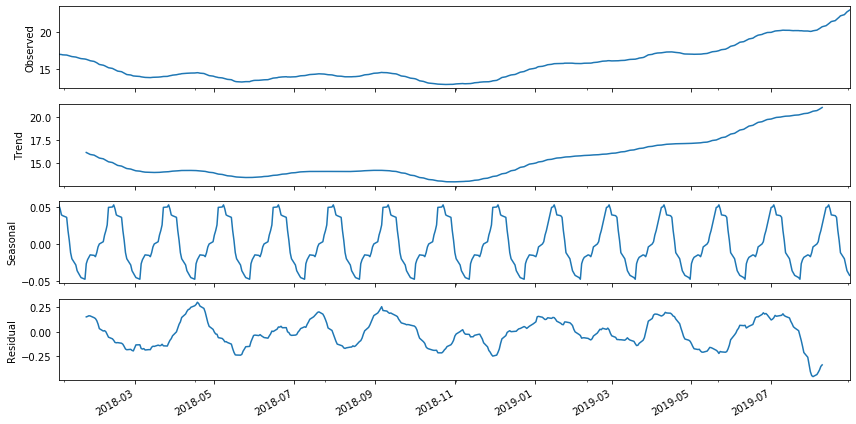

In [25]:
decomp20 = sm.tsa.seasonal_decompose(ma20, model='additive', freq=30)

plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams.update({'font.size': 10})
decomp20.plot()
None

From the plot of $S_t$ and $MA_{S_t}^{(N)}$ dynamics as well as from Stationarity Hypothesis test and "Regimes switching" and "Seasonality decomposition" above we can conclude that spread $S_t$ itself as well as its Moving Averages are **stationary** and have an obvious **upward trend**. We can also conclude that in both $S_t$ and $MA_{S_t}^{(N)}$ presents a seasonal "component". At the same time we do not observe any "regimes switching" in the dynamics of the spread and its Moving Averages.